In [ ]:
# ===== 导入必要的库 =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== 读取原始 CSV 数据 =====
products = pd.read_csv("olist_products_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv", parse_dates=[
    'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")

# ===== 基础处理，计算延误天数等 =====
orders = orders.dropna(subset=[
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'order_purchase_timestamp'
])
orders['delay_days'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days
orders['delay_days'] = orders['delay_days'].apply(lambda x: x if x > 0 and x <= 30 else 0)
orders['shipping_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# ===== 合并表格生成 order_full =====
order_full = orders.merge(items, on='order_id', how='left')
order_full = order_full.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
order_full = order_full.merge(payments[['order_id', 'payment_value']], on='order_id', how='left')
order_full = order_full.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')

# ===== 翻译商品类别（若要用英文名称）=====
product_cat_trans = pd.read_csv("product_category_name_translation.csv")
order_full = order_full.merge(product_cat_trans, on='product_category_name', how='left')

# ===== 创建延误标签字段 is_delayed =====
order_full['is_delayed'] = order_full['delay_days'].apply(lambda x: 1 if x > 1 else 0)

# ===== 构建 top_sellers 表（延误率高且数量多）=====
seller_delay = order_full.groupby('seller_id').agg({
    'is_delayed': ['mean', 'count']
})
seller_delay.columns = ['delay_rate', 'order_count']
top_sellers = seller_delay[seller_delay['order_count'] > 50].sort_values('delay_rate', ascending=False)


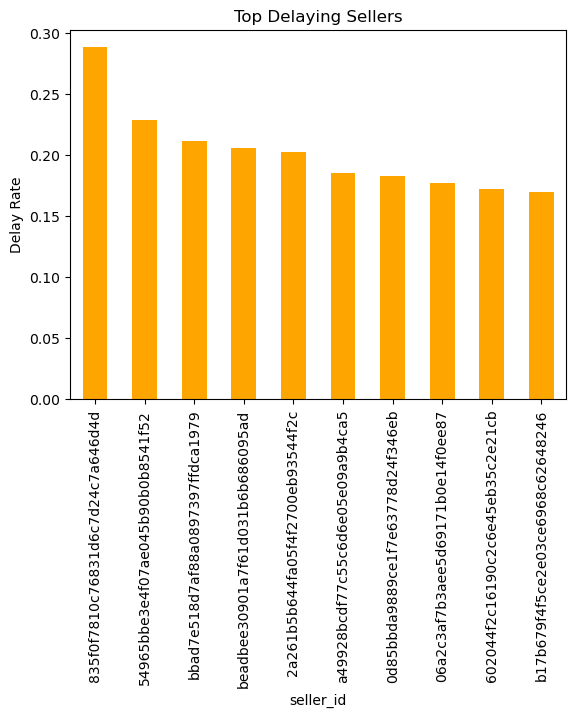

In [5]:
# 哪些seller延误最多（延误率高 + 数量多）
seller_delay = order_full.groupby('seller_id').agg({
    'is_delayed': ['mean', 'count']
})
seller_delay.columns = ['delay_rate', 'order_count']
top_sellers = seller_delay[seller_delay['order_count'] > 50].sort_values('delay_rate', ascending=False)

top_sellers.head(10).plot(kind='bar', y='delay_rate', title='Top Delaying Sellers', color='orange', legend=False)
plt.ylabel("Delay Rate")
plt.show()


In [10]:
# 获取 Top 10 延误率最高的 seller
top_seller_ids = top_sellers.head(10).index.tolist()

# 筛选出这些 seller 对应的订单
seller_orders = order_full[order_full['seller_id'].isin(top_seller_ids)]

# 按 seller_id 和 产品类别 分组，统计数量
seller_category_summary = seller_orders.groupby(['seller_id', 'product_category_name_english']) \
                                       .size().reset_index(name='count')

# 每个 seller 只保留销量最多的那个类别（主卖品类）
top_seller_main_cat = seller_category_summary.sort_values('count', ascending=False) \
                                             .drop_duplicates(subset='seller_id')

# 显示结果
top_seller_main_cat


,seller_id,product_category_name_english,count
0,06a2c3af7b3aee5d69171b0e14f0ee87,health_beauty,407
11,a49928bcdf77c55c6d6e05e09a9b4ca5,toys,93
4,2a261b5b644fa05f4f2700eb93544f2c,furniture_decor,84
5,54965bbe3e4f07ae045b90b0b8541f52,bed_bath_table,83
6,602044f2c16190c2c6e45eb35c2e21cb,bed_bath_table,58
22,beadbee30901a7f61d031b6b686095ad,health_beauty,58
13,b17b679f4f5ce2e03ce6968c62648246,health_beauty,52
14,bbad7e518d7af88a0897397ffdca1979,baby,46
8,835f0f7810c76831d6c7d24c7a646d4d,housewares,38
3,0d85bbda9889ce1f7e63778d24f346eb,stationery,33


In [11]:
# 计算 seller 和产品类别组合的延误率和订单数
seller_orders['is_delayed'] = seller_orders['delay_days'].apply(lambda x: 1 if x > 1 else 0)

seller_cat_delay = seller_orders.groupby(['seller_id', 'product_category_name_english']) \
    .agg(delay_rate=('is_delayed', 'mean'), order_count=('is_delayed', 'count')) \
    .reset_index()

# 按延误率排序，保留每个 seller 延误率最高的主销品类
top_delay_main_cat = seller_cat_delay.sort_values(['seller_id', 'delay_rate'], ascending=[True, False]) \
    .drop_duplicates('seller_id') \
    .sort_values('delay_rate', ascending=False) \
    .reset_index(drop=True)

# 只保留相关字段展示
display(top_delay_main_cat[['seller_id', 'product_category_name_english', 'delay_rate', 'order_count']].head(10))


/var/folders/pl/2h31dnhx49s3vqnb89w_bk580000gn/T/ipykernel_32345/2410160395.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seller_orders['is_delayed'] = seller_orders['delay_days'].apply(lambda x: 1 if x > 1 else 0)


,seller_id,product_category_name_english,delay_rate,order_count
0,bbad7e518d7af88a0897397ffdca1979,garden_tools,0.714286,14
1,835f0f7810c76831d6c7d24c7a646d4d,fashion_male_clothing,0.571429,14
2,a49928bcdf77c55c6d6e05e09a9b4ca5,housewares,0.333333,3
3,0d85bbda9889ce1f7e63778d24f346eb,christmas_supplies,0.318182,22
4,54965bbe3e4f07ae045b90b0b8541f52,bed_bath_table,0.228916,83
5,beadbee30901a7f61d031b6b686095ad,health_beauty,0.224138,58
6,2a261b5b644fa05f4f2700eb93544f2c,furniture_decor,0.202381,84
7,06a2c3af7b3aee5d69171b0e14f0ee87,health_beauty,0.176904,407
8,b17b679f4f5ce2e03ce6968c62648246,health_beauty,0.173077,52
9,602044f2c16190c2c6e45eb35c2e21cb,bed_bath_table,0.172414,58


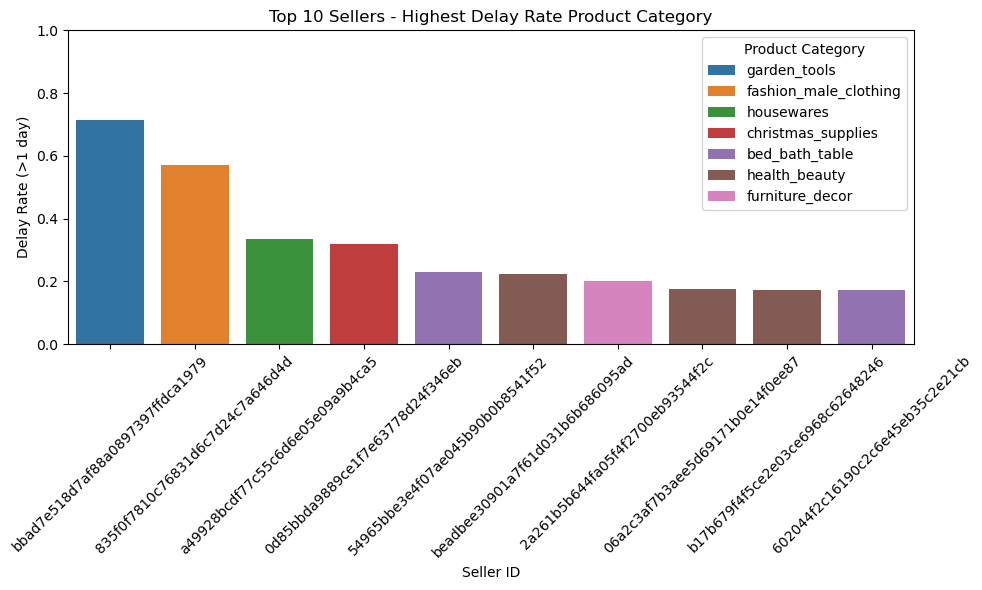

In [15]:
# 将原始类别合并英文翻译
product_cat_trans = pd.read_csv("product_category_name_translation.csv")

# 将产品类别英文 merge 到 orders 里
seller_orders = seller_orders.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
seller_orders = seller_orders.merge(product_cat_trans, on='product_category_name', how='left')

# 绘制 Top 10 延误 seller 在主打延误品类上的延误率图
plt.figure(figsize=(10, 6))
sns.barplot(data=top_delay_main_cat, x='seller_id', y='delay_rate', hue='product_category_name_english', dodge=False)
plt.title("Top 10 Sellers - Highest Delay Rate Product Category")
plt.ylabel("Delay Rate (>1 day)")
plt.xlabel("Seller ID")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title="Product Category")
plt.tight_layout()
plt.show()


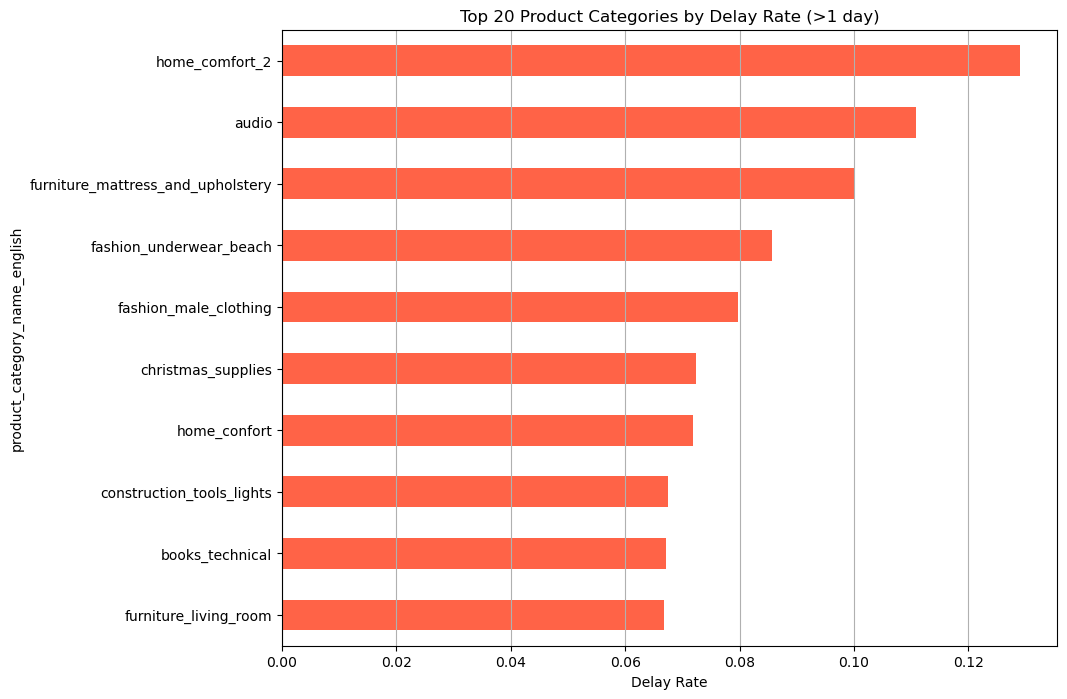

In [14]:
# 加载翻译表
cat_trans = pd.read_csv("product_category_name_translation.csv")

# 合并产品类别翻译
order_full = order_full.merge(cat_trans, on='product_category_name', how='left')
# 定义延误天数
order_full['is_delayed'] = order_full['delay_days'].apply(lambda x: 1 if x > 1 else 0)

import matplotlib.pyplot as plt

# 按英文产品类别分组计算平均延误率（1 表示延误）
category_delay = order_full.groupby('product_category_name_english')['is_delayed'] \
                           .mean().sort_values(ascending=False)

# 画图：Top 20 延误率最高的产品类别
plt.figure(figsize=(10, 8))
category_delay.head(10).plot(kind='barh', color='tomato')
plt.title("Top 20 Product Categories by Delay Rate (>1 day)")
plt.xlabel("Delay Rate")
plt.gca().invert_yaxis()  # 为了让延误率高的在上面
plt.grid(axis='x')
plt.show()

